### Tasks
- Identify 5 features from this data set and apply feature engineering on them in Python
- Make atleast 5 data visualization using various python packages

### Dataset
Dataset from ruter (Akershus and Oslo) containg 6000 entries with 17 datapoints
- TurID
- Dato
- Lokasjon (Fylke, Område, Kommune)
- Holdeplass (Fra, Til)
- Linjeinfo (Fylke, Navn, Retning)
- Tidspunkter (Ankomst og Avgang, Planlagt og Faktisk)
- Passasjerer (Kapasitet, Antall)

### Notes
Timeformat can be over 24 h, eg. 25h meaning next day and one hour
Passasjerer_Ombord is purely the difference between the number of passangers that got in and out on that stop (can be negative)

**Ideas for features and visualizations**
- Kommune with biggest number of entries
- Kommune with highest number of Passasjerer Ombord
- Lines with highest number of unused seats
- Most popular times
- Lines with highest frequency of delays
- Time of day versus delays
- Delays versus number of passengers
- Busiest weekdays
- Regions with highest change in traffic on weekdays versus weekend
- Regions versus delays

## (0) Prerequisites

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plot
import matplotlib
data = pd.read_csv("../datasets/Ruter_data.csv", delimiter=';')

In [66]:
data.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10


In [4]:
data.shape

(6000, 17)

## (1) Busiest Week Days

In [289]:
# Had some trouble getting dates in proper format (ddmmyyyy), so i made sure i worked every time with this method
def format_date(date) : 
    d, m, y = map(int, date.split('/'))
    return pd.Timestamp(day=d, month=m, year=y)

In [290]:
# We map the date column to now display weekday instead
d = data.assign(Dato = data.Dato.apply(lambda col: format_date(col).dayofweek))
d

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,0,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,5,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,0,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,0,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,3,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,10001-2020-06-10T15:10:00+02:00,2,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,1,16:23:18,16:23:48,16:10:00,16:10:00,151,2
5996,10010-2020-06-23T05:54:00+02:00,1,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,0,06:00:32,06:00:40,05:59:00,05:59:00,151,2
5997,2007-2020-06-11T17:22:00+02:00,3,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,1,17:42:43,17:43:10,17:32:00,17:32:00,106,3
5998,10004-2020-08-13T04:59:00+02:00,3,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,0,06:00:11,06:00:23,05:59:00,05:59:00,151,5


<AxesSubplot:xlabel='Dato'>

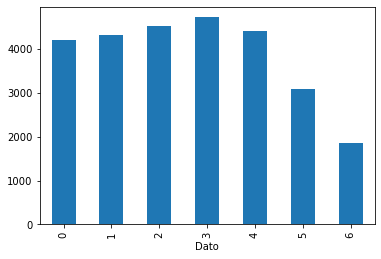

In [338]:
# If we now group by weekday, and sum the rest of the columns
s = d.groupby(by=('Dato')).sum()['Passasjerer_Ombord']
s.plot.bar()

We are really only iterested in weekdays, so we cut of the weekend

<AxesSubplot:xlabel='Dato'>

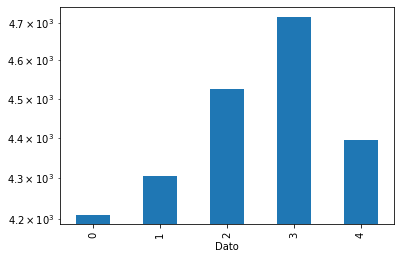

In [340]:
s[:5].plot.bar(logy=True)

We clearly see here that thursday is the most trafficed day

## (2) Passengers per Line

In [376]:
# We select name of line and passengers from data
passengers = data[['Linjenavn', 'Passasjerer_Ombord']]
# We then group by name of the line, and sum all passengers on that line
ppl = passengers.groupby(by=('Linjenavn')).sum()

This now contains 150 different lines, lets look closer at the top 10

<AxesSubplot:xlabel='Linjenavn'>

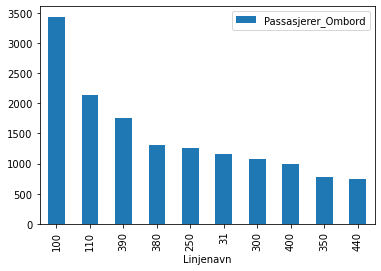

In [387]:
# If we first sort by number of passengers and then take head, we get the top
dataframe = pd.DataFrame(ppl.sort_values(by='Passasjerer_Ombord', ascending=False).head(10))
dataframe.plot.bar()

## (5) Calendar Contour Plot

In [26]:
# There seems to be some lines in the data where the actual arival time is null. Bus missing?

# We need a function for calculating delay
def delay(actual, expected) : return clean_hour(actual) - clean_hour(expected)

def clean_hour(time) : return pd.Timestamp(str(int(time[0:2]) % 24) + time[2:])

def format_date(date) : 
    d, m, y = map(int, date.split('/'))
    return pd.Timestamp(day=d, month=m, year=y)
    
expected_arrivals = data['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra']
actual_arrivals = data['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra']
dates = data['Dato']

# Restructure data with new datapoint 'Delay'
int_data = {'Hour' : [], 'Day of Week' : [], 'Delay': []}

for i in range(len(data)) :
    # Some datapoints contain no data for actual arrival time, meaning something failed or the bus never reached its stop
    # Ignoring those entries
    try: 
        hour = clean_hour(actual_arrivals[i]).hour
        day = format_date(dates[i]).dayofweek
        dt = delay(actual_arrivals[i], expected_arrivals[i]).total_seconds()
    except ValueError:
        continue
    
    int_data['Hour'].append(hour)
    int_data['Day of Week'].append(day)
    int_data['Delay'].append(dt)
    
dataframe = pd.DataFrame(data=int_data)
dataframe

,Hour,Day of Week,Delay
0,10,0,53.0
1,13,5,20.0
2,10,0,-4.0
3,13,0,64.0
4,7,3,73.0
...,...,...,...
5945,16,2,798.0
5946,6,1,92.0
5947,17,3,643.0
5948,6,3,71.0


Calender is now a 24 x 7 matrix containing either an empty lists, if no busses drove at that time, a single value if only one bus did, or multiple values where we need to take the average

Now that we have our data, lets look for outliers, describe() and a simple histogram will do

In [27]:
dataframe.Delay.describe()

count     5950.000000
mean       107.185378
std       1163.606064
min      -2585.000000
25%         30.000000
50%         85.000000
75%        159.000000
max      86241.000000
Name: Delay, dtype: float64

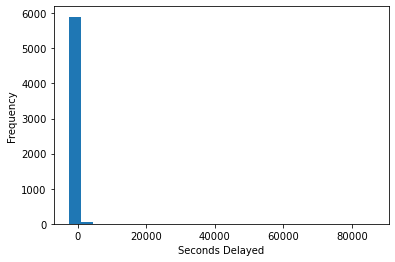

In [28]:
plot.hist(dataframe.Delay, bins=25, rwidth=1)
plot.xlabel('Seconds Delayed')
plot.ylabel('Frequency')
plot.show()

Although some busses are delayed for exorbant amounts of time, and others arriving over half an hour early, we are really only interested in busses ariving perfectly on time, til about an hour late. 

In [224]:
lower, upper = dataframe.Delay.quantile([0.14, 0.39])
lower, upper

(0.0, 60.0)

Cutting out the bottom 14 and the top 51 percentile seems to do just that

In [225]:
cut_dataframe = dataframe[(dataframe.Delay > lower) & (dataframe.Delay < upper)]

# Now that the dataframe is substantially smaller, if we want to iterate over it again by index, then we need to reset the indices
cut_dataframe.reset_index(inplace=True)
cut_dataframe

,index,Hour,Day of Week,Delay
0,0,10,0,53.0
1,1,13,5,20.0
2,7,6,0,24.0
3,14,18,4,40.0
4,23,12,1,2.0
...,...,...,...,...
1453,5934,15,0,22.0
1454,5935,12,2,57.0
1455,5939,13,6,5.0
1456,5941,18,6,51.0


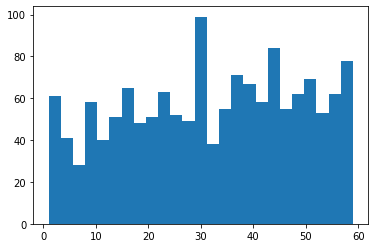

In [226]:
plot.hist(cut_dataframe.Delay, bins=25, rwidth=1)
plot.show()

Now the date looks a bit tidier, onto the plotting

In [227]:
# Create empty data structure
calender = [[[] for x in range(7)] for y in range(24)]

# Lets take the delay data and plot it according to time of day and day of week
for i in range(len(cut_dataframe)) : 
    hour = cut_dataframe['Hour'][i]
    day = cut_dataframe['Day of Week'][i]
    calender[hour][day].append(cut_dataframe['Delay'][i])

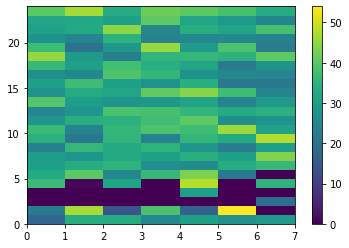

In [228]:
for y in range(24) :
    for x in range(7) :
        s = calender[y][x]
        if len(s) >= 2 :   # Take average
            calender[y][x] = np.mean(s)
        elif len(s) == 1 : # Use single value
            calender[y][x] = s[0]
        else:              # Ignore
            calender[y][x] = 0
    
c = plot.pcolormesh(calender)
plot.colorbar(c)
plot.show()

( Lite påvikret av rushtiden )

**Countour plot of delays**

A Contour plot with each point resembling a unique average hour of the week, colored according to the difference in planned and actual arrival times at that time. This should draw out a really clear illustration of rush traffic, hopefully resembling a calender with days in the week on one axis, and hours in the day on the other axis.

- Data sorted by day
- Data sorted by expected arrival hour

1. Make a 2D array data structure (24, 7)
2. Iterate over elements in said array and get all turIDs at corresponding time and date
3. Calculate their respective difference in expected and actual arrival time
4. Average this out for each time instance
5. Plot on contour
6. Tweak thresholds for aesthetic pleasing 😎